### Raster Data to Explore
    Landscan
    Worldpop
    NTL - DMSP & VIIRS
    Africapolic 
    EU Human Settlement Layer
    MODIS built layer
    Facebook Human Settlement
    GRUMP
    
### Define Urban Density
    Go w/ former US Census threshold of >= 1000 ppl per sq mile
    https://www2.census.gov/geo/pdfs/reference/GARM/Ch12GARM.pdf
    
    http://blogs.worldbank.org/sustainablecities/what-does-urban-mean

In [4]:
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from rasterio.mask import mask
import pandas as pd
import geopandas as gpd
import fiona
import rasterio
import numpy as np
import skimage.io as skio
import time
import copy

In [ ]:
# will build out folders later

# data folder git will ignore
infilepath = "/home/cascade/tana-crunch-cascade/projects/NTL/data/" 

# data folder git will not ignore - NO BIG FILES 
outfilepath = "/home/cascade/tana-crunch-cascade/projects/NTL/temp_data/"

In [6]:
# when work on local computer

infilepath = '/Users/cascade/Github/NTL/data/raw/worldpop/Africa-1km-Population/'
outfilepath = '/Users/cascade/Github/NTL/temp_data/'

# Step 1 - Input file

    Becomes a rasterio object, check meta data 
    Bands are numpy arrays

In [ ]:
africa1k_2000 = rasterio.open(infilepath+"AFR_PPP_2020_adj_v2.tif") #<----- changes to 2020 18/13/11 @ 2pm 
africa1k_2000.meta

# Step 2 - Make a mask

    Becomes a rasterio object, check meta data 
    Bands are numpy arrays

In [ ]:
# https://www2.census.gov/geo/pdfs/reference/ua/Defining_Rural.pdf

density = 1000/ 2.59 #density per sq km from sq mi
print(density)

In [ ]:
# Let's try to make the mask directy with rasterio
checkpoint = time.time()

new_mask = africa1k_2000.read(1)
new_mask[new_mask < 600] = 0 #18-11-12 set w/ 600 people
new_mask[new_mask > 600] = 1 #18-11-12 set w/ 600 people
print(np.unique(new_mask)) # ensure that it's zeros and ones

# plot.show(new_mask) # Sanity check 
print('elasped time to do the quary:{}'.format(time.time() - checkpoint))

In [ ]:
# Write out 600 ppl/km2 for QGIS
kwargs = africa1k_2000.meta
kwargs.update(dtype=rasterio.float32, count = 1)

with rasterio.open(infilepath+'africa1k_2020_mask600.tif', 'w', **kwargs) as dst:
        dst.write_band(1, new_mask.astype(rasterio.float32))


### Dilate and Erode 
With 3x3 kernal ... must be odd number to stay centered 

In [ ]:
# With 3x3 kernal ... must be odd number to stay centered  
# try dilate, erode, open and close

import cv2

kernal = np.ones((3,3), np.uint8)
mask_dilated_close = cv2.morphologyEx(new_mask, cv2.MORPH_CLOSE, kernal)
mask_dilated_open = cv2.morphologyEx(new_mask, cv2.MORPH_OPEN, kernal)
mask_erode = cv2.erode(new_mask, kernal, iterations = 1)
mask_dilate = cv2.dilate(new_mask, kernal, iterations = 1)

# write them out and check in QGIS
# ----------------> Need to do this without writing files <-----
kwargs = africa1k_2000.meta

# Update kwargs (change in data type)
kwargs.update(dtype=rasterio.float32, count = 1)

# Let's see what is in there
print(kwargs)

# erode check
# with rasterio.open(infilepath+'africa1k_2020_maskErode.tif', 'w', **kwargs) as dst:
#         dst.write_band(1, mask_erode.astype(rasterio.float32))

# dilate check 
# with rasterio.open(infilepath+'africa1k_2020_maskDilate.tif', 'w', **kwargs) as dst:
#         dst.write_band(1, mask_dilate.astype(rasterio.float32)) 
        
# close raster check
# with rasterio.open(infilepath+'africa1k_2020_maskClose.tif', 'w', **kwargs) as dst:
#         dst.write_band(1, mask_dilated_close.astype(rasterio.float32))

# open raster check        
# with rasterio.open(infilepath+'africa1k_2020_maskOpen.tif', 'w', **kwargs) as dst:
#         dst.write_band(1, mask_dilated_open.astype(rasterio.float32))

#plot.show(mask_dilated)

#### Notes
- Dilate alone connects too many cites
- Erode alone may make too few cities
- Open greatly reduces the number of polygons but may be best for a conservitive estimate
- Close connects them and may make it difficult to attach the correct label with correct political boundaries

# Step 3 - ShapeFiles

In [ ]:
# open dialated mask and make some polygons
checkpoint = time.time()

from rasterio import features as features

with rasterio.open(infilepath+'africa1k_2020_mask600.tif') as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.read(1)

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6) # WGS84 (EPSG 4326)

print("elapsed time is: {}s".format(time.time()-checkpoint))

Don't need to write outfile as shapes ... can do is-inside script without making shape
But write it out so you don't have to keep rerunning the above code block

In [ ]:
# import json

# with open(outfilepath+'WP2000_mask600_poly.json', 'w') as fp:
#      json.dump(geom, fp)

In [ ]:
# Sanity check
print(len(geom['coordinates']))
print(geom.keys())

In [ ]:
# Turn rasterio geom dict into a polygon

from shapely.geometry import Polygon

def build_poly_df(geom):
    """
    This function makes polygons from rasterio geom dict
    """
    
    # turn dict into normal data frame
    Polygon(geom['coordinates'][0])
    geo_df = gpd.GeoDataFrame()
    for i, poly in enumerate(geom['coordinates']):
        geo_df.loc[i,'geometry']= Polygon(poly)
    return geo_df

In [ ]:
poly_geo_df = build_poly_df(geom)

In [ ]:
poly_geo_df.head(6)

In [ ]:
poly_geo_df.shape

#### I think I need to drop the first row because it's the footprint of the raster

In [ ]:
poly_geo_df_copy = copy.deepcopy(poly_geo_df)

In [ ]:
# I think I need to drop the first row because it's the footprint of the raster
poly_geo_df_copy = poly_geo_df_copy.drop(poly_geo_df_copy.index[0], axis = 0)

In [ ]:
poly_geo_df_copy.shape

In [ ]:
# write out polygons from mask 600 on WorldPop Africa 1km year 2000 

poly_geo_df_copy.to_csv(outfilepath+"20181113_poly_cities_africa2020mask600.csv")

### Pull in OSM cities and turn into geo data frame

In [ ]:
import pandas as pd
from shapely.geometry import Point

osm_df = pd.read_csv(outfilepath+'africa_cities.csv')

# creating a geometry column 
geometry = [Point(xy) for xy in zip(osm_df['lon'], osm_df['lat'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
osm_gdf = gpd.GeoDataFrame(osm_df, crs=crs, geometry=geometry)

In [ ]:
# building a function to check if points are in poly for lists of poly and points
# needs geopandas data frame with point and poly geometry 

from shapely.geometry import mapping

def poly_point (poly, point):
    """
    This function will check if points are inside polygons if given two gpds with points and polygons
    Returns city names or no list 
    """
    
    out_arr = [] #return an array <<< ---------------- ASK RYAN IF BETTER DO USE DICT 
    
    for index_point, row_point in point.iterrows():
        for index_poly, row_poly in poly.iterrows():
            if row_point['geometry'].within(row_poly['geometry']):
                country = row_point['Country']
                city = row_point['City']
                point_id = row_point['Id']
                point_geom = mapping(row_point['geometry']) # makes a dict w/ keys : type and cood
                poly_id = index_poly
                poly_geom = mapping(row_poly['geometry']) # makes a dict w/ keys : type and cood
                
                out_arr.append((country, 
                                city, 
                                point_id, 
                                point_geom, 
                                poly_id, 
                                poly_geom))
#             else:
#                 test.append('no')
    return out_arr

In [ ]:
# 863 total cities in osm, 26974 polygons took 1578 seconds for 2000
# 863 total cities in osm, 42241 polygons took XXXX seconds for 2020

sub_point = osm_gdf.iloc[0:4]
sub_poly = poly_geo_df_copy.iloc[0:1000] #<----- With copy, drop raster foot print polygon

# print(sub_point.shape)
# print(sub_poly.shape)
# print(sub_point)
# print(sub_poly)

In [ ]:
osm_gdf.shape

In [ ]:
check_point = time.time()

# (poly then points)
test = poly_point(poly_geo_df_copy, osm_gdf)
print(len(test))

print("elapsed time is: {}s".format(time.time()-check_point))



In [ ]:
# Can convert back to dataframe if needed ... 

coords_arr = np.array(test)
coords_arr

# Try to make it into a dataframe
test_df = pd.DataFrame(data=coords_arr)
test_df

In [ ]:
test_df.to_csv(outfilepath+"20181113_polypoints_WP2020_africa.csv")

# When working on home computer not Tana start here 18.11.13

    tasks
    - suck in .csv with cities for 2000 and 2020
    - turn polygons into shape files
    - turn shape files into masks
    - use masks to return raster stats for the polygons

In [25]:
# open polypoints csvs

polypoints_2000_df =  pd.read_csv(outfilepath+'20181113_polypoints_WP2000_africa.csv')
polypoints_2020_df =  pd.read_csv(outfilepath+'20181113_polypoints_WP2020_africa.csv')

print(polypoints_2000_df.head(1))
#print(polypoints_2020_df.head(1))

   Unnamed: 0        0            1         2  \
0           0  Algeria  Constantine  27564946   

                                                   3     4  \
0  {'type': 'Point', 'coordinates': (6.6082600000...  1085   

                                                   5  
0  {'type': 'Polygon', 'coordinates': (((6.616249...  


In [26]:
polypoints_2000_df.columns = ['i_val','country','city','osm_id',
                             'point_geom','poly_id','poly_geom']

polypoints_2020_df.columns = ['i_val','country','city','osm_id',
                             'point_geom','poly_id','poly_geom']
print(polypoints_2000_df.head(1))

   i_val  country         city    osm_id  \
0      0  Algeria  Constantine  27564946   

                                          point_geom  poly_id  \
0  {'type': 'Point', 'coordinates': (6.6082600000...     1085   

                                           poly_geom  
0  {'type': 'Polygon', 'coordinates': (((6.616249...  


In [39]:
from shapely.geometry import shape
import ast

test_1 = []
test_2 = []

for i in polypoints_2020_df['poly_geom']:
    i = (ast.literal_eval(i))
    test_1.append((i))
    
for j in test_1:
    j = shape(j)
    test_2.append((j))
    
# for poly in polypoints_2000_df.iloc[:,6]:
#     poly = shape(ast.literal_eval(poly))
#     test.append = (poly)

#polypoints_2020_df['poly_geom'] = polypoints_2020_df['poly_geom'].apply(ast.literal_eval())
polypoints_2020_df['geometry'] = test_2

In [42]:
polypoints_2020_gdf = gpd.GeoDataFrame(polypoints_2020_df, geometry='geometry')
polypoints_2000_gdf = gpd.GeoDataFrame(polypoints_2000_df, geometry='geometry')

In [45]:
# polypoints_2000_gdf.to_file(outfilepath+'20181113_shape_WP2000_africa.shp', driver='ESRI Shapefile')
# polypoints_2020_gdf.to_file(outfilepath+'20181113_shape_WP2020_africa.shp', driver='ESRI Shapefile')

### THE CODE BELOW WILL TURN YOUR CSV BACK INTO SHAPELY OBJECTS :-)
- Next step is to put into a gpdf and then make it into shape files ... write it as a loop. 

<class 'dict'>


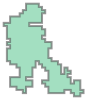

In [41]:
from shapely.geometry import shape
import ast

test_poly = ast.literal_eval(polypoints_2000_df.iloc[0,6])
print(type(test_poly))

test = shape(test_poly)
test

### The cell below this works ... makes a shapefile 

In [ ]:
# Explort it as a shape file
# careful with the file path ... this is going to my notebooks folder right now
# newer_pdf.to_file('worldpop_2000_test.shp', driver='ESRI Shapefile')

In [ ]:
# Let's see if I can find zonal stats

In [ ]:
# https://automating-gis-processes.github.io/CSC18/lessons/L6/zonal-statistics.html

from rasterstats import zonal_stats

In [ ]:
# Need to figure out how to turn geo pandas back into a geojson dict
with fiona.open("worldpop_2000_test.shp", "r") as shapefile:                                #<--- Need to figure out how to get the geometry from shp file directly 
    features = [feature["geometry"] for feature in shapefile]

with rasterio.open(filepath+"AFR_PPP_2000_adj_v2.tif") as src:                        #<--- Need to figure out how to get it not to write to a file, but just store in memory at this point
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(filepath+"AFR_PPP_2000_adj_MASK.tif", "w", **out_meta) as dest:
    dest.write(out_image) 


In [ ]:
mask_test_2000 = rasterio.open(filepath+'AFR_PPP_2000_adj_MASK.tif')
plot.show(mask_test_2000)

In [ ]:
np.unique(mask_test_2000.read(1))

In [ ]:
# from shapely.geometry import shape

# test = shape(geom)
# type(test)

In [ ]:
# get it into a geopandas DF for explore
import geopandas as gp
geom_gdf = gp.GeoDataFrame.from_records(geom)
type(geom_gdf)

In [ ]:
# check it 
geom_gdf.head(2)

In [ ]:
geom_gdf[type=='Polygon'] = 'POLYGON '
geom_gdf.head(2)

In [ ]:
geom_gdf['geometry']=geom_gdf['False'].astype(str)+geom_gdf['coordinates'].astype(str)

In [ ]:
geom_gdf.head(6)

In [ ]:
test = gp.GeoDataFrame(geom_gdf['geometry'])
test.head(6)

In [ ]:
# try to write it as a shape file
test.to_file('worldpop_2000_test.shp', driver='ESRI Shapefile')

In [ ]:
type(dst)

In [ ]:
dir(africa1k_2000_poly)

In [ ]:
test = rasterio.features.dataset_features(africa1k_2000_poly)







In [ ]:
type(test)

In [ ]:
# ask Kelly about what to do with the nodata values messing everything up 
ghana100m_2010 = rasterio.open(filepath+"GHA10_040213.tif")
ghana100m_2010.meta

In [ ]:
plot.show(ghana100m_2010)

In [ ]:
ghana100m_2010_arr = ghana100m_2010.read_band(1)

In [ ]:
# check data range
np.unique(ghana100m_2010_arr)

In [ ]:
# Zoom into a subset
#window = rasterio.windows.Window(1024, 1024, 1280, 2560)

subset = ghana100m_2010.read(1, window=((7000, 7200), (2700, 3300)))

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
#plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [ ]:
type(subset)

In [ ]:
plt.hist(subset, range = [0,100])
plt.show()

In [ ]:
import copy

subset_copy = copy.copy(subset)
subset_copy[subset<1] = 0

In [ ]:
plt.figure(figsize=(6,8.5))
plt.imshow(subset_copy)
plt.colorbar(shrink=0.5)
plt.xlabel('Column #')
plt.ylabel('Row #')

In [ ]:
plt.hist(subset_copy)
plt.show()

In [ ]:
test = rasterio.open(filepath+"GHA10_040213.tif")

In [ ]:
test.mask

In [ ]:
type(test_band)

In [ ]:
from rasterio.features import shapes
mask = None
with rasterio.drivers():
    with rasterio.open(filepath+"GHA10_040213.tif", window = ((7000, 7200), (2700, 3300))) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.affine)))

In [ ]:
geoms = list(results)

In [ ]:
print(geoms[4])

In [ ]:
import geopandas as gp
gpd_polygonized_raster  = gp.GeoDataFrame.from_features(geoms)

In [ ]:
gpd_polygonized_raster

# OLD CODE

In [ ]:
# Sanity check on number of polygons 
# from skimage import measvure
# label_test = measure.label(mask_dilated, background=0, return_num=True)
# label_test_arr = label_test[0]
# label_test_num = label_test[1] # 96 polygons
# label_test_num

In [ ]:
# test_point = osm_gdf.iloc[4]['geometry']
# test_poly = poly_geo_df.iloc[0]['geometry']
# print(test_poly.contains(test_point))
# print(test_point.within(test_poly))

In [ ]:
# test if point is inside poly
checkpoint = time.time()

test_point = osm_gdf.iloc[30]['geometry']
test_poly = poly_geo_df.iloc[2]['geometry']
print(test_poly.contains(test_point))
print(test_point.within(test_poly))
print(test_poly)
print(test_point)`

In [ ]:
# Sanity check on number of polygons 
from skimage import measure
label_test = measure.label(new_mask, background=0, 
                           connectivity = 2, # diagonal connect
                           #neighbors = 8,
                           return_num=True)
label_test_arr = label_test[0]
label_test_num = label_test[1] # 96 polygons

# no connectivity change 38377